In [1]:
%matplotlib inline
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import math
import pylab as pl

## Constants

In [2]:
# physical constants from ICON
dtime      = 600       # model time step [s]
Ki         = 2.1656    # heat conductivity ice        [J/(msK)]
Ks         = 0.31      # heat conductivity snow       [J/(msK)]
rhoi      = 917.0     # density of sea ice  [kg/m^3]
rhos      = 300       # density of snow     [kg/m^3]
rhow      = 1025.022  # density of ocean water [kg/m^3]
ci        = 2106      # heat capacity of ice [J/(kgK)]
cs        = 2090      # heat capacity of snow [J/(kgK)]
Tf         = -1.9      # freezing temperature of ocean water [°C]
Tmelt      = 273.15    # melting temperature of water [K]
zemissdef = 0.996     # longwave emissivity factor   [] ICON
#zemissdef = 1-0.7     # longwave emissivity factor   [] Abbot(2010)
sigma      = 5.6704e-8 # Stefan-Boltzman constant     [W/(m^2K^4)]
# albedo values defined in runscript!
albsnow_warm     = 0.66
albsnow_cold     = 0.79
albice_warm      = 0.38
albice_cold      = 0.45
I0        = 0.17      # ice surface penetrating radiation []
L         = 2.8345e6 - 2.5008e6 # latent heat of fusion [J/kg]
muS       = 0.054 * 5.0  # constant of linear salt - freezing point relationship * Sea ice bulk salinity [°C]

hcilayer  = 0.1       # thickness of stabilizing constant heat capacity layer [m]



## Functions

In [3]:
# functions
def E(T):   
    return ci*(T+muS)-L*(1+muS/T) # enthalpy of melting for upper layer [J/kg] #(1)
def E2(T):
    return ci*(T+muS)-L      # enthalpy of melting for lower layer [J/kg] #(25)

def legend_color(ax, handle_array, pos, fontsize):
    legend = ax.legend(handle_array,handlelength=0, handletextpad=0, edgecolor='none', facecolor='none', markerscale=0, loc=pos, fontsize=fontsize)
    for item in legend.legendHandles:
        item.set_visible(False)
    for text in legend.get_texts():
        if text.get_text()=='Winton':
            text.set_color('C1')
        if text.get_text()=='3L-Winton':
            text.set_color('C1')
        elif text.get_text()=='Semtner':
            text.set_color('C0')
        elif text.get_text()=='0L-Semtner':
            text.set_color('C0')
        elif text.get_text()=='Semtner_5m':
            text.set_color('C2')
        elif text.get_text()=='0L-Semtner-lim5':
            text.set_color('C2')
        elif text.get_text()=='1438ppmv':
            text.set_color('C0')
        elif text.get_text()=='1500ppmv':
            text.set_color('C1')
        elif text.get_text()=='3000ppmv':
            text.set_color('C2')
        elif text.get_text()=='5000ppmv':
            text.set_color('C3')

    return legend

In [4]:
print(E2(-muS))
print(L)

-333700.0
333700.0


## Winton model (including calculation of surface fluxes)

In [5]:
# surface fluxes (not actually part of the Winton Model!)
def surface_fluxes(Tsurfold, hsold, rsds, rlds, lhflx, shflx, albedo, I0):
    #print("calculate surface fluxes")
    # check for snow on ice
    if hsold>0: 
        I=0           # fraction of penetrating radiation []
        #print("snow on ice")
    else: 
        I=I0
        #print("bare ice")
    if hsold>1e-6:  # ICON checks diferently for Tsurfmelt and I!
        Tsurfmelt = 0 # melting temperature of surface [°C]
        #print("snow on ice")
    else: 
        Tsurfmelt = - muS
        #print("bare ice")

    # surface energy flux balance 
    # longwave incoming + longwave outgoing  + shortwave balance + latent heat flux + sensible heat flux
    SWnet = rsds * (1-albedo)
    FS = 1* ( zemissdef *(rlds  - sigma* (Tsurfold+Tmelt)**4 )  +  SWnet*(1-I)    +   lhflx   +   shflx ) #UPWARD flux!
    dFS = -4 * zemissdef * sigma * (Tsurfold+Tmelt)**3
    
    #print("FS  = " +str(FS) +" W/m^2")
    #print("dFS = " +str(dFS)  +" + " +str(rhoi * hcilayer /dtime *ci) +" W/(m^2K)")
    
    return FS, dFS, SWnet, I, Tsurfmelt 


# 2.a) temperature calculation
def set_ice_temp(Tsurfold, T1old, T2old, hiold, hsold, FS, dFS, SWnet, I, Tsurfmelt, c_stability=True):
#    if hsold>1e-6: 
#        I=0           # fraction of penetrating radiation []
#        Tsurfmelt = 0 # melting temperature of surface [°C]
#        print("snow on ice")
#    else: 
#        Tsurfmelt = - muS
#        I=I0          # fraction of penetrating radiation []
#        print("bare ice")
    
    # Factor B + stabilizing ice layer in ICON ?
    # stabilizing ice layer dominates the sensitivity of temperature on surface flux balance -> surface temperature is far less sensitive
    B = -dFS               #(8)
    if c_stability:
        B = B+rhoi * hcilayer /dtime *ci 
    A = -FS - Tsurfold * B                                   #(7)

    #conductivities
    K12 = (4*Ki*Ks) / (Ks*hiold + 4*Ki*hsold)  # coupled conductivity of snow-ice layer (upper layer) [W/(mK)] (5)
    K32 = 2*Ki/hiold                           # coupled conductivity of both ice layers (lower layer) [W/(mK)] (10)


    A1 = (rhoi*hiold)/(2*dtime) * ci + K32*(4*dtime*K32+rhoi*hiold*ci)/(6*dtime*K32+rhoi*hiold*ci) + (K12*B)/(K12+B)   # (16)
    B1 = -1*(rhoi*hiold)/(2*dtime) * (ci*T1old - (L*muS)/T1old) - SWnet * I - \
    K32 * (4*dtime*K32*Tf + rhoi*hiold*ci*T2old)/(6*dtime*K32 + rhoi*hiold*ci) + (A*K12)/(K12+B)          # (17)
    C1 = -1 * (rhoi*hiold)/(2*dtime) * L *muS

    # temperature T1
    T1 = -1 * (B1+ (B1**2 - 4*A1*C1)**0.5)/(2*A1)                                         # (21)

    # temperature T2 (not necessary to calculate here?)
    T2 = (2 * dtime * K32 * (T1 + 2*Tf) + rhoi*hiold*ci*T2old) / (6 * dtime * K32 + rhoi * hiold * ci)   #(15)

    # surface temperature
    Tsurf = (K12 * T1 - A) / (K12 + B)      # (6)
    #print(K12,A,B)

    if Tsurf>Tsurfmelt: #check for melting of upper snow or ice surface
        #print("surface melting")
        Tsurf = Tsurfmelt
        
        # recalculate A1 & B1 for surface melting
        A1 = (rhoi*hiold)/(2*dtime) * ci + K32*(4*dtime*K32+rhoi*hiold*ci)/(6*dtime*K32+rhoi*hiold*ci) + K12   # (19)
        B1 = -1*(rhoi*hiold)/(2*dtime) * (ci*T1old - (L*muS)/T1old) - SWnet * I- \
        K32 * (4*dtime*K32*Tf + rhoi*hiold*ci*T2old)/(6*dtime*K32 + rhoi*hiold*ci) + K12*Tsurf              # (20)

        # recalculate T1 & T2
        T1 = -1 * (B1+ (B1**2 - 4*A1*C1)**0.5)/(2*A1)                                         # (21)
        T2 = (2 * dtime * K32 * (T1 + 2*Tf) + rhoi*hiold*ci*T2old) / (6 * dtime * K32 + rhoi * hiold * ci)   #(15)

        Qtop = K12 * (T1-Tsurf) - (A+B*Tsurf)                    # (22)
    else:
        Qtop = 0

    Qbot = -4 * Ki * (Tf-T2)/hiold                           # (23)

    # calculated values 
    #print("Tsurf: " +str(Tsurfold) +" -> " +str(Tsurf) +" °C")
    #print("T1:    " +str(T1old) +" -> " +str(T1) +" °C")
    #print("T2:    " +str(T2old) +" -> " +str(T2) +" °C")

    #print("Qbot= " +str(Qbot) +" W/m^2")
    #print("Qtop= " +str(Qtop) +" W/m^2")

    # Temeperatures may change in the ice growth scheme!
    # ICON output values
    #print("ICON: ")
    #print("Tsurf: " +str(Tsurfold) +" -> " +str(Tsurf_ICON) +" °C")
    #print("T1:    " +str(T1old) +" -> " +str(T1_ICON) +" °C")
    #print("T2:    " +str(T2old) +" -> " +str(T2_ICON) +" °C")
    
    return Tsurf, T1, T2, Qbot, Qtop



# 2.b) ice thickness calculation

def ice_growth(hiold, hsold, Tsurf, T1, T2, Qbot, Qtop, prls, prcs):
    # snow thickness calculation
    #print("calculate snow accumulation")
    hs=hsold +(prls+prcs)*dtime / rhos

    #print("hs:    " +str(hsold) +" -> " +str(hs) +" m")

    # initialize h1 & h2
    h1=hiold/2
    h2=hiold/2


    #print("calculate ice thickness change")
    # bottom accretion
    dhi_bot=0
    
    if Qbot<0:
        #print("bottom accretion")
        dh2 = Qbot * dtime / (rhoi * E2(Tf))        #(24)  
        dhi_bot = dh2
        T2 = (dh2*Tf + h2*T2)/(dh2 + h2)     #temperature change of lower ice layer due to added mass (26)
        h2 += dh2  
        
    hi = h1+h2
    
    fluxres_w=0
    # surface melting
    dhi_top=0
    if Qtop>0:
        #print("surface melting")
        dhs = -min(    (Qtop*dtime)                            /(L        *rhos)    ,hs)        #(27)
        dh1 = -min(max((Qtop*dtime - L*hs*rhos)                /(-1*E(T1) *rhoi),0 ),h1)         #(28)
        dh2 = -min(max((Qtop*dtime - L*hs*rhos + E(T1)*h1*rhoi)/(-1*E2(T2)*rhoi),0 ),h2)        #(29)
        dhi_top=dhs+dh1+dh2
        fluxres_w = max(Qtop*dtime - L*hs + E(T1)*hiold + E2(T2)*h2 ,0)               #(30)
        h1 += dh1
        h2 += dh2
        hs += dhs

    # bottom melting
    if Qbot>0:
        #print("bottom melting")
        dh2 = -min(    (Qbot*dtime)                                 /(-E2(T2)*rhoi)   ,h2)      #(31)
        dh1 = -min(max((Qbot*dtime + E2(T2)*h2*rhoi)                /(-E(T1)*rhoi) ,0),h1)      #(32)
        dhs = -min(max((Qbot*dtime + E2(T2)*h2*rhoi + E(T1)*h1*rhoi)/(L*rhos)      ,0),hs)      #(33)
        dhi_bot = dh2+dh1+dhs
        
        fluxres_w += max(Qbot*dtime - L*hs + E(T1)*hiold + E2(T2)+h2, 0)
        h1 += dh1
        h2 += dh2
        hs += dhs
    
    hi = h1+h2

    # snow ice conversion
    
    draft = (rhoi*hi + rhos*hs)/rhow
    below_water = draft - hi
    
    if (below_water>0 and ci>0):
        print("convert snow to ice")
        snow_to_ice = below_water * rhoi/rhos
        
        hs = hs - snow_to_ice
        
        # adjust T1 due to incorporation of zero heat capacity snow
        f1 = h1/(h1+below_water)
        Tbar = f1 * (T1- (L/ci) * (muS/T1)) + (1-f1)*(-muS)        # (39) with T2=-muS
        T1 = (Tbar - (Tbar**2 + 4*muS*L / ci)**0.5)/2              # (38)

        h1 = h1 + below_water
        hi = h1+h2
        

    # even up h1 & h2 and change temperature accordingly
    if h1>h2 and ci>0:
        #print("convert h1 to h2")

        f1 = h1/(0.5*hi)-1
        Tbar = f1 * (T1- (L/ci) * (muS/T1)) + (1-f1)*(T2)        # (39) 
        T2 = Tbar                                                # (40)
    elif h2>h1 and ci>0:
        #print("convert h2 to h1")  

        f1 = h1/(0.5*hi) 
        Tbar = f1 * (T1- (L/ci) * (muS/T1)) + (1-f1)*(T2)        # (39) 
        T1 = (Tbar - (Tbar**2 + 4*muS*L / ci)**0.5)/2            # (38)


    # check if T2>-muS through ice conversion
    # not explicitly defined in Winton (2000), taken from the ICON code
    # available energy h2*ci*(T2 + muS) is used t euqally melt upper and lower layer with enthalpies E(T1) and E2(-muS)
    if T2>-muS:
        print("T2 over bulk melting temperature: melting")
        #hi = hi - h2*ci*(T2 + muS) / (0.5*L- 0.5*(ci*(T1 +muS) - L * (1+muS/T1)))
        hi = hi - h2*ci*(T2 + muS) / (-0.5* E(T1) - 0.5* E2(-muS))
        T2=-muS
    
    #print("hi:    " +str(hiold) +"  -> " +str(hi) +" (" +str(hi_ICON)  +") m")
    #print("hs:    " +str(hsold) +"  -> " +str(hs) +" (" +str(hs_ICON)  +") m")
    #print("Tsurf: " +str(Tsurfold) +" -> " +str(Tsurf) +" (" +str(Tsurf_ICON)  +") °C")
    #print("T1:    " +str(T1old) +"  -> " +str(T1) +" (" +str(T1_ICON)  +") °C")
    #print("T2:    " +str(T2old) +" -> " +str(T2) +" (" +str(T2_ICON)  +") °C")

    #print("")
    return hi, hs, T1, T2, fluxres_w, dhi_top, dhi_bot

## Semtner 0L model (including calculation of surface fluxes)

In [6]:
# surface fluxes 
def surface_fluxes_semtner(Tsurfold, rsds, rlds, lhflx, shflx, albedo):
    #print("calculate surface fluxes")

    # surface energy flux balance 
    # longwave incoming + longwave outgoing  + shortwave balance + latent heat flux + sensible heat flux
    # in ICON: addition of zemissdef
    SWnet = rsds * (1-albedo) # = swflx_ice
    nonsolar_ice = 1* ( zemissdef *(rlds  - sigma* (Tsurfold+Tmelt)**4 )  +   lhflx   +   shflx ) #UPWARD flux # =nonsolar_ice!
    dnonsolarT = -4 * zemissdef * sigma * (Tsurfold+Tmelt)**3 # dnonsolarT
    
    #print("FS  = " +str(FS) +" W/m^2")
    #print("dFS = " +str(dFS)  +" + " +str(rhoi * hcilayer /dtime *ci) +" W/(m^2K)")
    
    return nonsolar_ice, dnonsolarT, SWnet


# set ice temperature
def set_ice_temp_semtner(Tsurfold, hiold, hsold, nonsolar_ice, dnonsolarT, SWnet, c_stability=True):
    
    # effective heat conductivity of ice&snow
    k_eff = (Ki * Ks) / (Ks*hiold + Ki*hsold) # in Semtner paper not a variable but used in the formula for Fs
    
    F_A = -1*nonsolar_ice - SWnet  # Flux from atmosphere, not in Semtner paper
    
    F_S = k_eff * (Tf - Tsurfold) # Flux into ice
    
    deltaTdenominator = k_eff - dnonsolarT   
    if c_stability:
        deltaTdenominator = deltaTdenominator +rhoi*hcilayer*ci/dtime # addition of constant heat capacity to stabilize surface temperture (not in Semtner paper)
    
    deltaT = (F_S - F_A) / deltaTdenominator
    
    if Tsurfold + deltaT > 0: # Tsurf > 0°C -> Surface melting
        deltaT = -Tsurfold
        Tsurf = 0
        
        Qtop = (F_S - F_A)  - deltaT * deltaTdenominator # Qtop >0 -> melting 
                                                         # (F_S - F_A) -> flux imbalance from old surface temperature Tsurfold
                                                         # Tsurfold * deltaTdenominator -> flux imbalance resulting from warming Tsurf to 0°C (Tsurfold in °C!)
        
        Qbot = - F_S + deltaT * k_eff # originally Qbot = -F_S
    else:
        Tsurf = Tsurfold + deltaT
        
        Qtop = 0
        Qbot = k_eff * (Tsurf - Tf)
        
    return Tsurf, Qbot, Qtop, F_A, F_S


def ice_growth_semtner(hiold, hsold, Tsurf, Qbot, Qtop, prls, prcs):
    
    #print("calculate snow accumulation")
    hs=hsold +(prls+prcs)*dtime / rhos
    
    if hs>0:
        
        dhi_top= - dtime * Qtop / (L*rhos)
        hs = max(hs + dhi_top,0)   # alf*rhos = qs
        hi = hiold
    else:
        dhi_top= - dtime * Qtop / (L*rhoi)
        hi = max(hiold + dhi_top,0)   # alf*rhoi = qi
        
    dhi_bot = - dtime * Qbot / (L*rhoi) # Qbot=-F_S; alf*rhoi = qi
    hi = hi + dhi_bot
    
    # snow ice conversion
    
    draft = (rhoi*hi + rhos*hs)/rhow
    below_water = draft - hi
    
    if below_water>0:
        print("convert snow to ice")
        snow_to_ice = below_water * rhoi/rhos
        hs = hs - snow_to_ice

       
        hi = hi + below_water

    return hi, hs, dhi_top, dhi_bot

## Albedo calculation (optional)

In [7]:
def set_albedo(hi, hs, Tsurf): # after set_ice_albedo in mo_sea_ice.f90 in ICON

    if hs>1e-2*rhow/rhos: # snow has to be thicker than 0.034m
        if Tsurf==0:
            albedo=albsnow_warm
        elif Tsurf <=-1:
            albedo=albsnow_cold
        else:
            albedo = (1 + Tsurf)*albsnow_warm - Tsurf*albsnow_cold

    else: # bare ice
        if Tsurf==0:
            albedo=albice_warm
        elif Tsurf <=-1:
            albedo=albice_cold
        else:
            albedo = (1 + Tsurf)*albice_warm - Tsurf*albice_cold
            
    
    return albedo
            

## Initial conditions

In [8]:
# initial conditions
init_Tsurf = -10
init_T1 = -10
init_T2 = -6
init_Qbot = 0
init_Qtop = 0
init_hi = 1
init_hs = 0
I0  = 0.17      # ice surface penetrating radiation []

prls = 0
prcs = 0
albedo_init = albice_cold
ci        = 2106      # heat capacity of ice [J/(kgK)]

# boundary conditions
lhflx = 0
shflx = 0

initial_conditions="rev1_cold"
if initial_conditions=="melting":
    # melting -> melt ratched effect with abbot (2010) zemissfac
    rlds = 0 
    shflx = 60 
    rsds = 500
    init_T1 = -1.9
    init_T2 = -1.9
    init_Tsurf = -3
    init_hi = 4
    rsds_offset=0
elif initial_conditions=="melting_icon":
    # melting -> melt ratched effect with ICON zemissfac
    rlds = 0
    shflx = 150
    rsds = 750
    init_T1 = -1.9
    init_T2 = -1.9
    init_Tsurf = -3
    init_hi = 4
    init_hs = 0
    rsds_offset=0
elif initial_conditions=="rev1":
    # melting -> melt ratched effect with ICON zemissfac
    rlds = 0
    shflx = 250
    rsds = 600
    init_T1 = -1.9
    init_T2 = -1.9
    init_Tsurf = -3
    init_hi = 4
    init_hs = 0
    I0  = 0.17      # ice surface penetrating radiation []
    rsds_offset=0
elif initial_conditions=="rev1_cold":
    # melting -> melt ratched effect with ICON zemissfac
    rlds = 0
    shflx = 250
    rsds = 600
    init_T1 = -8
    init_T2 = -4
    init_Tsurf = -5
    init_hi = 4
    init_hs = 0
    I0  = 0.17      # ice surface penetrating radiation []
    rsds_offset=0
elif initial_conditions=="rev1_norad":
    # melting -> melt ratched effect with ICON zemissfac
    rlds = 0
    shflx = 300
    rsds = 600
    init_T1 = -6
    init_T2 = -4
    init_Tsurf = -3
    init_hi = 4
    init_hs = 0
    I0=0
    rsds_offset=0
elif initial_conditions=="rev1_snow":
    # melting -> melt ratched effect with ICON zemissfac
    rlds = 0
    shflx = 300
    rsds = 600
    init_T1 = -6
    init_T2 = -3
    init_Tsurf = -3
    init_hi = 4
    init_hs = 1
    I0=0.17
    rsds_offset=0
elif initial_conditions=="rev1_norad_warm":
    # melting -> melt ratched effect with ICON zemissfac
    rlds = 0
    shflx = 250
    rsds = 600
    init_T1 = -1.9
    init_T2 = -1.9
    init_Tsurf = -3
    init_hi = 4
    init_hs = 0
    I0=0
    rsds_offset=0
elif initial_conditions=="noc_I":
    # melting -> melt ratched effect with ICON zemissfac
    rlds = 0
    shflx = 250
    rsds = 600
    init_T1 = -5
    init_T2 = -3
    init_Tsurf = -3
    init_hi = 4
    init_hs = 0
    I0  = 0.17      # ice surface penetrating radiation []
    rsds_offset=0
    ci        = 0.00000      # heat capacity of ice [J/(kgK)]
elif initial_conditions=="noI_c":
    # melting -> melt ratched effect with ICON zemissfac
    rlds = 0
    shflx = 250
    rsds = 600
    init_T1 = -8
    init_T2 = -5
    init_Tsurf = -3
    init_hi = 4
    init_hs = 0
    I0  = 0     # ice surface penetrating radiation []
    rsds_offset=0
elif initial_conditions=="noc_noI":
    # melting -> melt ratched effect with ICON zemissfac
    rlds = 0
    shflx = 250
    rsds = 600
    init_T1 = -1.9
    init_T2 = -1.9
    init_Tsurf = -3
    init_hi = 4
    init_hs = 0
    I0  = 0     # ice surface penetrating radiation []
    rsds_offset=0
    ci=0
elif initial_conditions=="rev1_norad_offset":
    # melting -> melt ratched effect with ICON zemissfac
    rlds = 0
    shflx = 100
    rsds = 600
    #init_T1 = -9
    #init_T2 = -4.2
    init_T1 = -6
    init_T2 = -3.5
    init_Tsurf = -3
    init_hi = 4
    init_hs = 0
    I0=0
    rsds_offset=200
elif initial_conditions=="heating":
    # melting -> melt ratched effect with ICON zemissfac
    rlds = 0
    shflx = 200
    rsds = 0
    #init_T1 = -9
    #init_T2 = -4.2
    init_T1 = -3
    init_T2 = -2
    init_Tsurf = -3
    init_hi = 4
    init_hs = 0
elif initial_conditions=="melting_snow":
    rlds = 0
    shflx = 150
    rsds = 750
    init_T1 = -20
    init_T2 = -15
    init_Tsurf = -5
    init_hi = 20
    init_hs = 1
    rsds_offset=0
elif initial_conditions=="freezing":
    #  freezing
    rlds = 0 
    shflx = 20
    init_hi = 2
    init_hs = 0.5
    rsds = 500
    #rlds = 100 
    #rsds = 200
    init_T1 = -9
    init_T2 = -5
    init_Tsurf = -5
    rsds_offset=0
elif initial_conditions=="freezing_2":
    #  freezing
    init_hi = 0.05
    init_hs = 0.0
    prls = 0
    rlds = 0 
    shflx = 20
    rsds = 500
    #rlds = 100 
    #rsds = 200
    init_T1 = -1.9
    init_T2 = -1.9
    init_Tsurf = -1.9
    rsds_offset=0
elif initial_conditions=="freezing_cold":
    #  freezing
    init_hi = 10
    init_hs = 0.0
    prls = 0
    rlds = 0 
    shflx = 20
    rsds = 500
    #rlds = 100 
    #rsds = 200
    init_T1 = -40
    init_T2 = -50
    init_Tsurf = -20
    rsds_offset=0
elif initial_conditions=="melting_cold":
    #  freezing
    init_hi = 10
    init_hs = 1.0
    prls = 0
    rlds = 0 
    shflx = 150
    rsds = 750
    #rlds = 100 
    #rsds = 200
    init_T1 = -100
    init_T2 = -100
    init_Tsurf = -60
    rsds_offset=0
elif initial_conditions=="melting_2":
    rlds = 120 
    rsds = 300
    init_hi = 1
    init_T1 = -5
    init_T2 = -3
    init_Tsurf = -8
    rsds_offset=0
elif initial_conditions=="snowball":
    shflx = -50
    rlds = 0
    rsds = 800
    init_T1 = -7
    init_T2 = -5
    init_Tsurf = -10
    init_hi = 20
    rsds_offset=0
elif initial_conditions=="abbot":
    shflx = 80 
    rlds = 0
    rsds = 40/ albedo_init
    init_T1 = -3.5
    init_T2 = -2.8
    init_Tsurf = -8
    rsds_offset=0
else:
    rlds=0
    rsds=0
    rsds_offset=0




#artificial radiative forcing
days = 31
spinupdays = 1
time_artificial=np.linspace(-int(spinupdays),int(days),(days+spinupdays)* int((60 * 60 * 24)/dtime)+1) # timestep has to be 600s = 10m = 1/6h = 1/144d 
                                                                     # = dtime / (60 * 60 * 24)
rsds_array_artificial = rsds*np.sin(time_artificial*2*np.pi-np.pi/2)
rsds_array_artificial[rsds_array_artificial<0]=0
rsds_array_artificial+=rsds_offset


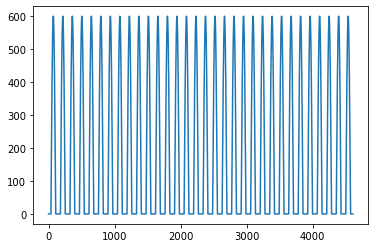

In [9]:
plt.plot(rsds_array_artificial)

## Winton model

Initial conditions are defined here. Albedo calculation is activatred or deactivated by commenting out the set_albedo function. The model breaks if the ice thickness is below 0m, there is no handling of minimal ice thickness implemented as in the ICON sea-ice scheme!

In [10]:
# run Winton model

# initial conditions
Tsurf = init_Tsurf
T1 = init_T1
T2 = init_T2
Qbot = init_Qbot
Qtop = init_Qtop
hi = init_hi
hs = init_hs
albedo = albedo_init

# result array
hi_result=[]
hi_result.append(hi)

hs_result=[]
hs_result.append(hs)

Tsurf_result=[]
Tsurf_result.append(Tsurf)

T1_result=[]
T1_result.append(T1)

T2_result=[]
T2_result.append(T2)

Qbot_result=[]
Qbot_result.append(Qbot)

Qtop_result=[]
Qtop_result.append(Qtop)

albedo_result=[]
albedo_result.append(albedo)

FS_result=[]

dhi_top_result=[0]
dhi_bop_result=[0]

SWnet_result=[]

for i in range(1,rsds_array_artificial.size):
    FS, dFS, SWnet, I, Tsurfmelt = surface_fluxes(Tsurf, hs, rsds_array_artificial[i], rlds, lhflx, shflx, albedo, I0)
    Tsurf, T1, T2, Qbot, Qtop = set_ice_temp(Tsurf, T1, T2, hi, hs, FS, dFS, SWnet, I, Tsurfmelt, True)
    #Qtop=0
    hi, hs, T1, T2, fluxres_w, dhi_top, dhi_bot = ice_growth(hi, hs, Tsurf, T1, T2, Qbot, Qtop, prls, prcs)
    #albedo = set_albedo(hi, hs, Tsurf)
    #print("time=", str(time_artificial[i]), " Tsurf=", str(Tsurf))

    
    # assign results to final array
    hi_result.append(hi)
    hs_result.append(hs)
    Tsurf_result.append(Tsurf)
    T1_result.append(T1)
    T2_result.append(T2)
    Qbot_result.append(Qbot)
    Qtop_result.append(Qtop)
    albedo_result.append(albedo)
    SWnet_result.append(SWnet)
    FS_result.append(FS)
    dhi_top_result.append(dhi_top)
    dhi_bop_result.append(dhi_bot)
    
    if hi<=0: 
        break
print(T1)
print(T2)


-2.8945598986783567
-2.6330313697641383


## Winton model without penetrating radiation

In [11]:
# run Winton model

# initial conditions
Tsurf = init_Tsurf
T1 = init_T1
T2 = init_T2
Qbot = init_Qbot
Qtop = init_Qtop
hi = init_hi
hs = init_hs
albedo = albedo_init

# result array
hi_norad_result=[]
hi_norad_result.append(hi)

hs_norad_result=[]
hs_norad_result.append(hs)

Tsurf_norad_result=[]
Tsurf_norad_result.append(Tsurf)

T1_norad_result=[]
T1_norad_result.append(T1)

T2_norad_result=[]
T2_norad_result.append(T2)

Qbot_norad_result=[]
Qbot_norad_result.append(Qbot)

Qtop_norad_result=[]
Qtop_norad_result.append(Qtop)

albedo_norad_result=[]
albedo_norad_result.append(albedo)

FS_norad_result=[]

dhi_top_norad_result=[0]
dhi_bop_norad_result=[0]

SWnet_norad_result=[]

for i in range(1,rsds_array_artificial.size):
    FS, dFS, SWnet, I, Tsurfmelt = surface_fluxes(Tsurf, hs, rsds_array_artificial[i], rlds, lhflx, shflx, albedo, 0)
    Tsurf, T1, T2, Qbot, Qtop = set_ice_temp(Tsurf, T1, T2, hi, hs, FS, dFS, SWnet, I, Tsurfmelt, True)
    #Qtop=0
    hi, hs, T1, T2, fluxres_w, dhi_top, dhi_bot = ice_growth(hi, hs, Tsurf, T1, T2, Qbot, Qtop, prls, prcs)
    #albedo = set_albedo(hi, hs, Tsurf)
    #print("time=", str(time_artificial[i]), " Tsurf=", str(Tsurf))

    
    # assign results to final array
    hi_norad_result.append(hi)
    hs_norad_result.append(hs)
    Tsurf_norad_result.append(Tsurf)
    T1_norad_result.append(T1)
    T2_norad_result.append(T2)
    Qbot_norad_result.append(Qbot)
    Qtop_norad_result.append(Qtop)
    albedo_norad_result.append(albedo)
    SWnet_norad_result.append(SWnet)
    FS_norad_result.append(FS)
    dhi_top_norad_result.append(dhi_top)
    dhi_bop_norad_result.append(dhi_bot)
    
    if hi<=0: 
        break
print(T1)
print(T2)


-5.210199822778797
-3.2413111858730286


## Semtner model

Initial conditions are defined here. Albedo calculation is activatred or deactivated by commenting out the set_albedo function. The model breaks if the ice thickness is below 0m, there is no handling of minimal ice thickness implemented as in the ICON sea-ice scheme!

In [12]:
# run semtner model 

# initial conditions
Tsurf = init_Tsurf
T1 = init_T1
T2 = init_T2
Qbot = init_Qbot
Qtop = init_Qtop
hi = init_hi
hs = init_hs
albedo = albedo_init

# result array
hi_result_Semtner=[]
hi_result_Semtner.append(hi)

hs_result_Semtner=[]
hs_result_Semtner.append(hs)

Tsurf_result_Semtner=[]
Tsurf_result_Semtner.append(Tsurf)

T1_result_Semtner=[]
T1_result_Semtner.append(T1)

T2_result_Semtner=[]
T2_result_Semtner.append(T2)

Qbot_result_Semtner=[]
Qbot_result_Semtner.append(Qbot)

Qtop_result_Semtner=[]
Qtop_result_Semtner.append(Qtop)

albedo_result_Semtner=[]
albedo_result_Semtner.append(albedo)

FS_result_Semtner=[]
FA_result_Semtner=[]
dhi_top_result_Semtner=[0]
dhi_bop_result_Semtner=[0]

SWnet_result_Semtner=[]

for i in range(1,rsds_array_artificial.size):
    nonsolar_ice, dnonsolarT, SWnet = surface_fluxes_semtner(Tsurf, rsds_array_artificial[i], rlds, lhflx, shflx, albedo)
    Tsurf, Qbot, Qtop, FA, FS = set_ice_temp_semtner(Tsurf, hi, hs, nonsolar_ice, dnonsolarT, SWnet, True)
    #Qtop=0
    hi, hs, dhi_top, dhi_bot = ice_growth_semtner(hi, hs, Tsurf, Qbot, Qtop, prls, prcs)
    #albedo = set_albedo(hi, hs, Tsurf)

    
    # assign results to final array
    hi_result_Semtner.append(hi)
    hs_result_Semtner.append(hs)
    Tsurf_result_Semtner.append(Tsurf)
    Qbot_result_Semtner.append(Qbot)
    Qtop_result_Semtner.append(Qtop)
    albedo_result_Semtner.append(albedo)
    SWnet_result_Semtner.append(SWnet)
    FS_result_Semtner.append(FS)
    FA_result_Semtner.append(FA)
    dhi_top_result_Semtner.append(dhi_top)
    dhi_bop_result_Semtner.append(dhi_bot)
    if hi<=0: 
        break

rev1_cold


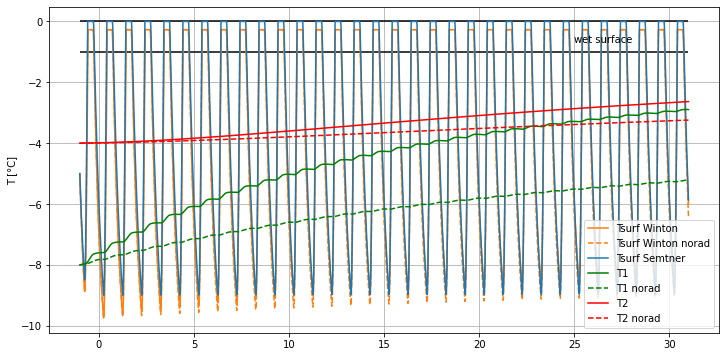

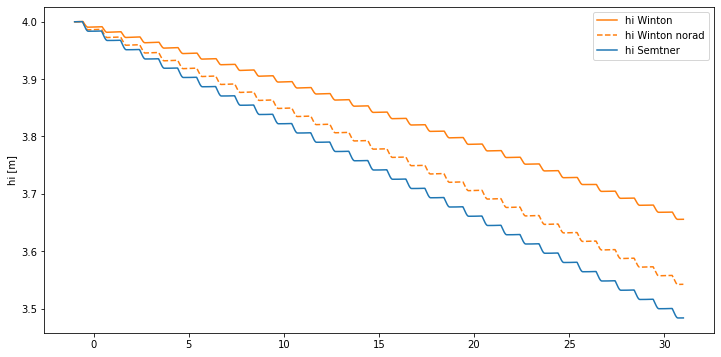

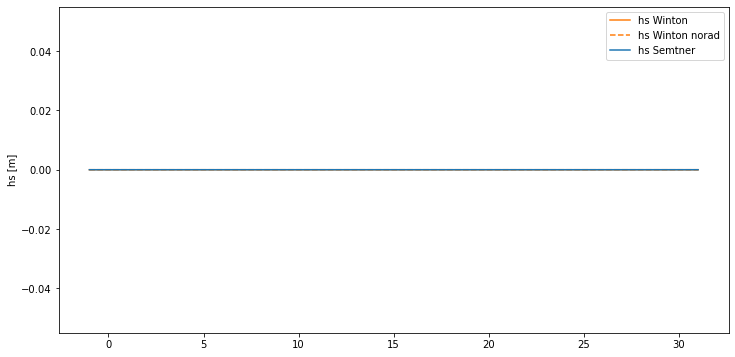

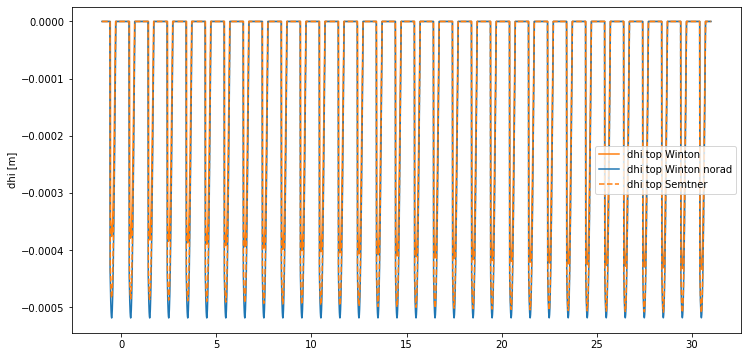

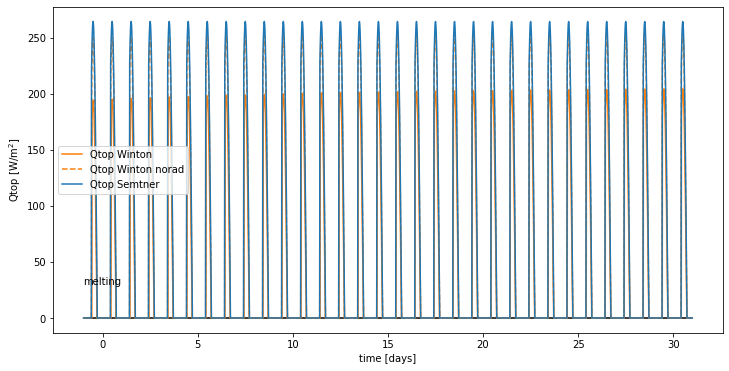

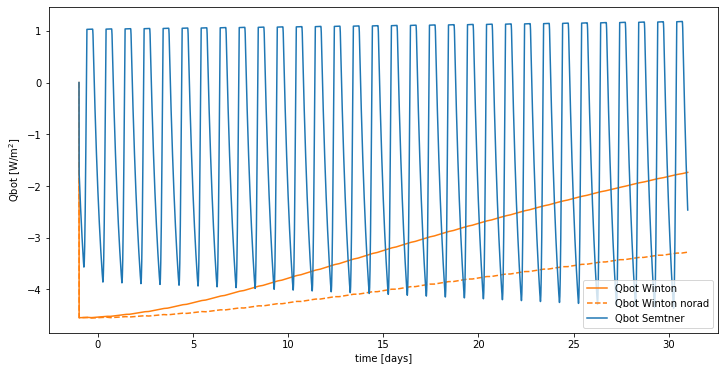

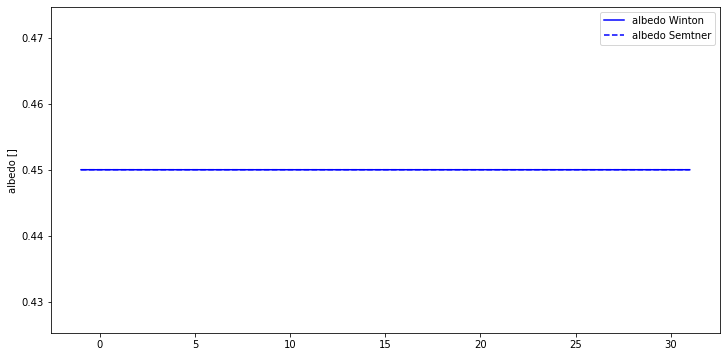

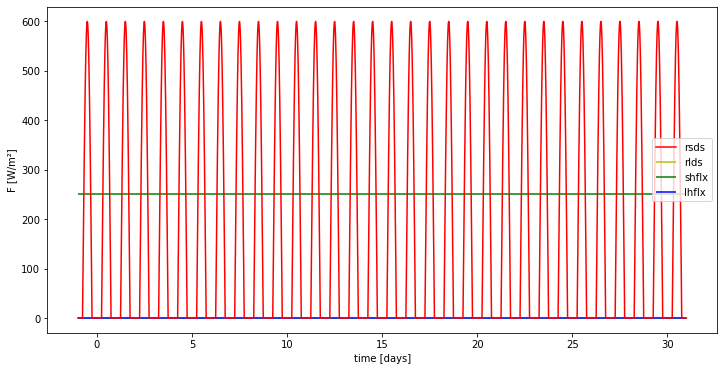

In [13]:
#plt.plot(hi_result)
#plt.plot(hi_array[0:10,lind])


titlestr = ""
print(initial_conditions)
# temperatures
fig, (ax1) = plt.subplots(nrows=1,sharex=True,figsize=(12,6))
plt.subplots_adjust(hspace=0)
plt.grid()
ax1.hlines(-1,time_artificial[0],time_artificial[-1],'black') 
ax1.hlines(0,time_artificial[0],time_artificial[-1],'black') 
ax1.annotate("wet surface",[25,-0.7])
ax1.plot(time_artificial,Tsurf_result,color='C1')
ax1.plot(time_artificial,Tsurf_norad_result,color='C1',ls='--')
ax1.plot(time_artificial,Tsurf_result_Semtner,color='C0')

ax1.plot(time_artificial,T1_result,c='g',ls='-')
ax1.plot(time_artificial,T1_norad_result,c='g',ls='--')
ax1.plot(time_artificial,T2_result,c='r',ls='-')
ax1.plot(time_artificial,T2_norad_result,c='r',ls='--')


ax1.legend(["Tsurf Winton","Tsurf Winton norad","Tsurf Semtner", "T1", "T1 norad", "T2", "T2 norad"])
#ax1.set_xticks([3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24],"")
ax1.set_ylabel("T [°C]")
ax1.set_title(titlestr)
plt.savefig("plots/temp.png",dpi=200)
plt.show()


# hi
fig, (ax1) = plt.subplots(nrows=1,sharex=True,figsize=(12,6))
plt.subplots_adjust(hspace=0)

ax1.plot(time_artificial,hi_result,c='C1',ls='-')
ax1.plot(time_artificial,hi_norad_result,c='C1',ls='--')

ax1.plot(time_artificial,hi_result_Semtner,c='C0',ls='-')
ax1.legend(["hi Winton", "hi Winton norad", "hi Semtner"])
ax1.set_ylabel("hi [m]")
#ax1.set_xticks([3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
ax1.set_title(titlestr)
ax1.ticklabel_format(axis='both', style='plain',useOffset=False)
plt.show()

# hs
fig, (ax1) = plt.subplots(nrows=1,sharex=True,figsize=(12,6))
plt.subplots_adjust(hspace=0)

ax1.plot(time_artificial,hs_result,c='C1',ls='-')
ax1.plot(time_artificial,hs_norad_result,c='C1',ls='--')

ax1.plot(time_artificial,hs_result_Semtner,c='C0',ls='-')

ax1.legend(["hs Winton", "hs Winton norad", "hs Semtner"])
ax1.set_ylabel("hs [m]")
#ax1.set_xticks([3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
ax1.set_title(titlestr)
ax1.ticklabel_format(axis='both', style='plain',useOffset=False)
plt.show()

#dhi
fig, (ax1) = plt.subplots(nrows=1,sharex=True,figsize=(12,6))
plt.subplots_adjust(hspace=0)

ax1.plot(time_artificial,dhi_top_result,c='C1',ls='-')
ax1.plot(time_artificial,dhi_top_result_Semtner,c='C0',ls='-')
ax1.plot(time_artificial,dhi_top_norad_result,c='C1',ls='--')

ax1.legend(["dhi top Winton", "dhi top Winton norad", "dhi top Semtner"])
ax1.set_ylabel("dhi [m]")
#ax1.set_xticks([3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
ax1.set_title(titlestr)
ax1.ticklabel_format(axis='both', style='plain',useOffset=False)
plt.show()


# Qtop
fig, (ax1) = plt.subplots(nrows=1,sharex=True,figsize=(12,6))
plt.subplots_adjust(hspace=0)

ax1.hlines(0,time_artificial[0],time_artificial[-1],'black') 
ax1.annotate("melting",[-1,30])
ax1.annotate("freezing",[-1,-30])

ax1.plot(time_artificial,Qtop_result,c='C1',ls='-')
ax1.plot(time_artificial,Qtop_norad_result,c='C1',ls='--')
ax1.plot(time_artificial,Qtop_result_Semtner,c='C0',ls='-')

ax1.legend(["Qtop Winton", "Qtop Winton norad", "Qtop Semtner"])
#ax1.set_xticks([3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
ax1.set_ylabel('Qtop [W/m$^2$]')
ax1.set_xlabel("time [days]")
ax1.set_title(titlestr)
ax1.ticklabel_format(axis='both', style='plain',useOffset=False)
plt.show()

# Qbot
fig, (ax1) = plt.subplots(nrows=1,sharex=True,figsize=(12,6))
plt.subplots_adjust(hspace=0)


ax1.plot(time_artificial,Qbot_result,c='C1',ls='-')
ax1.plot(time_artificial,Qbot_norad_result,c='C1',ls='--')
ax1.plot(time_artificial,Qbot_result_Semtner,c='C0',ls='-')

ax1.legend(["Qbot Winton", "Qbot Winton norad", "Qbot Semtner"])
#ax1.set_xticks([3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
ax1.set_ylabel('Qbot [W/m$^2$]')
ax1.set_xlabel("time [days]")
ax1.set_title(titlestr)
ax1.ticklabel_format(axis='both', style='plain',useOffset=False)
plt.show()

# albedo
fig, (ax1) = plt.subplots(nrows=1,sharex=True,figsize=(12,6))
plt.subplots_adjust(hspace=0)

ax1.plot(time_artificial,albedo_result,'b-')
ax1.plot(time_artificial,albedo_result_Semtner,'b--')
ax1.legend(["albedo Winton", "albedo Semtner"])
ax1.set_ylabel("albedo []")
#ax1.set_xticks([3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
ax1.set_title(titlestr)
ax1.ticklabel_format(axis='both', style='plain',useOffset=False)
plt.show()

# rsds
fig, (ax1) = plt.subplots(nrows=1,sharex=True,figsize=(12,6))
plt.subplots_adjust(hspace=0)

ax1.plot(time_artificial,rsds_array_artificial,'r-')
plt.hlines(rlds,time_artificial[0],time_artificial[-1],'y') #
plt.hlines(shflx,time_artificial[0],time_artificial[-1],'g') # shflx
plt.hlines(lhflx,time_artificial[0],time_artificial[-1],'b') #lhflx
ax1.set_xlabel("time [days]")
ax1.set_ylabel("F [W/m²]")
plt.legend(["rsds", "rlds", "shflx", "lhflx"])
ax1.set_title(titlestr)
ax1.ticklabel_format(axis='both', style='plain',useOffset=False)


Qbot Semtner=-1.0032236823600755
Qbot Winton=-4.349632279446178
Qbot norad Winton=-4.481430975289241
Qtop Semtner=58.15248070974257
Qtop Winton=37.34387444901312
Qtop norad Winton=53.04918409268154
0.05480208193694436
264.5691017881027
198.69599766988318


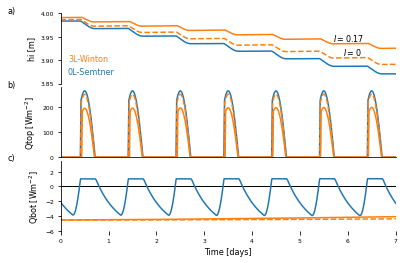

In [14]:
labelsize = 8
ticksize = 6

if initial_conditions=="melting_icon" or initial_conditions=="melting"  or initial_conditions=="rev1_norad_offset":
    hilim=[3.95,4]
    qtoplim=[0,280]
    qbotlim=[-15,4]
elif initial_conditions=="melting_snow":
    hslim=[0.8,1]
    qtoplim=[0,150]
    qbotlim=[-10,10]
elif initial_conditions=="freezing" or initial_conditions=="freezing_2":
    qbotlim=[-240,0]
    qtoplim=[0,300]
    hilim=[0,0.4]
elif initial_conditions=="rev1" or initial_conditions=="rev1_norad":
    hilim=[3.85,4]
    qtoplim=[0,280]
    qbotlim=[-5,4]
elif initial_conditions=="rev1_cold":
    hilim=[3.85,4]
    qtoplim=[0,280]
    qbotlim=[-6,3.5]
else:
    hilim=[3.8,4]
    qtoplim=[0,280]
    qbotlim=[-15,4]
    
    

#hi
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(6,4))
#plt.subplots_adjust(hspace=0)


if init_hs==0:
    ax1.plot(time_artificial,hi_result_Semtner,color='C0',linestyle='-')
    ax1.plot(time_artificial,hi_result,color='C1',linestyle='-')
    ax1.plot(time_artificial,hi_norad_result,color='C1',linestyle='--')

    legend = legend_color(ax1,['3L-Winton','0L-Semtner'],3, labelsize)
    ax1.set_ylabel("hi [m]", fontsize=labelsize)
    #ax1.ticklabel_format(axis='both', style='plain',useOffset=False)
    ax1.set_xlim(0,7)
    ax1.set_ylim(hilim[0],hilim[1])
    ax1.xaxis.set_ticks_position('none')
    ax1.set_xticklabels('')
    ax1.tick_params(labelsize=ticksize) 
else:
    ax1.plot(time_artificial,hs_result_Semtner,color='C0',linestyle='-')
    ax1.plot(time_artificial,hs_result,color='C1',linestyle='-')
    ax1.plot(time_artificial,hs_norad_result,color='C1',linestyle='--')

    legend = legend_color(ax1,['3L-Winton','0L-Semtner'],1, labelsize)
    ax1.set_ylabel("hs [m]")
    #ax1.ticklabel_format(axis='both', style='plain',useOffset=False)
    ax1.set_xlim(0,7)
    ax1.set_ylim(hslim[0],hslim[1])
    ax1.xaxis.set_ticks_position('none')
    ax1.set_xticklabels('')
    ax1.tick_params(labelsize=ticksize) 
    



# qtop
ax2.plot(time_artificial,Qtop_result_Semtner,color='C0',linestyle='-')
ax2.plot(time_artificial,Qtop_result,color='C1',linestyle='-')
ax2.plot(time_artificial,Qtop_norad_result,color='C1',linestyle='--')
#ax2.legend(["Qtop Semtner","Qtop Winton"],loc=1)
ax2.set_ylabel("Qtop [Wm$^{-2}$]", fontsize=labelsize)
#ax2.ticklabel_format(axis='both', style='plain',useOffset=False)
ax2.set_ylim(qtoplim[0],qtoplim[1])
ax2.xaxis.set_ticks_position('none')
ax2.set_xticklabels('')
ax2.tick_params(labelsize=ticksize) 
ax2.set_xlim(0,7)
#ax2.hlines(0,0,7,lw=1,color='black')


# qbot
ax3.hlines(0,0,7,lw=1,color='black')
ax3.plot(time_artificial,Qbot_result_Semtner,color='C0',linestyle='-')
ax3.plot(time_artificial,Qbot_result,color='C1',linestyle='-')
ax3.plot(time_artificial,Qbot_norad_result,color='C1',linestyle='--')
#ax3.legend(["Qbot Semtner","Qbot Winton"],loc=1)
ax3.set_ylabel("Qbot [Wm$^{-2}$]", fontsize=labelsize)
#ax3.ticklabel_format(axis='both', style='plain',useOffset=False)
ax3.set_ylim(qbotlim[0],qbotlim[1])
ax3.ticklabel_format(axis='both', style='plain',useOffset=False)
ax3.tick_params(labelsize=ticksize) 

ax3.set_xlabel("Time [days]", fontsize=labelsize)
ax3.set_xlim(0,7)

ax1.spines['right'].set_color('none')
ax2.spines['right'].set_color('none')
ax3.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax2.spines['top'].set_color('none')
ax3.spines['top'].set_color('none')
ax1.spines['bottom'].set_color('none')
#ax2.spines['bottom'].set_color('none')
ax3.spines['bottom'].set_color('none')

ax1.annotate("$I=0$",[5.9,3.91], fontsize=labelsize)
ax1.annotate("$I=0.17$",[5.7,3.94], fontsize=labelsize)

plt.subplots_adjust(hspace=0.05)
ax1.text(-0.16,1,"a)", transform=ax1.transAxes, fontsize=labelsize)
ax2.text(-0.16,1,"b)", transform=ax2.transAxes, fontsize=labelsize)
ax3.text(-0.16,1,"c)", transform=ax3.transAxes, fontsize=labelsize)


plt.savefig("plots/model_hi_qtop_qbot_{}.pdf".format(initial_conditions))
plt.savefig("plots/model_hi_qtop_qbot_{}.png".format(initial_conditions),dpi=200)

print("Qbot Semtner=" +str(np.mean(Qbot_result_Semtner[1*24*6:8*24*6])))
print("Qbot Winton=" +str(np.mean(Qbot_result[1*24*6:8*24*6])))
print("Qbot norad Winton=" +str(np.mean(Qbot_norad_result[1*24*6:8*24*6])))
print("Qtop Semtner=" +str(np.mean(Qtop_result_Semtner[1*24*6:8*24*6])))
print("Qtop Winton=" +str(np.mean(Qtop_result[1*24*6:8*24*6])))
print("Qtop norad Winton=" +str(np.mean(Qtop_norad_result[1*24*6:8*24*6])))


print(hi_result[8*24*6]-hi_result_Semtner[8*24*6])
print(np.max(Qtop_result_Semtner[1*24*6:8*24*6]))
print(np.max(Qtop_result[1*24*6:8*24*6]))